# Payoff d'un condor call sur SPY

Condor (long K1, short K2, short K3, long K4) : plateau central, payoff/P&L net et points morts.


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import sys
from pathlib import Path
from IPython.display import display, Markdown

_base = Path.cwd().resolve()
for extra in (_base, _base.parent, _base.parent.parent):
    candidate = extra / "notebooks" / "scripts"
    if candidate.exists() and str(candidate) not in sys.path:
        sys.path.insert(0, str(candidate))
        break
from pricing import fetch_spy_history, view_condor, payoff_condor
plt.style.use("seaborn-v0_8-darkgrid")

close_spy = fetch_spy_history()
spot_ref = float(close_spy.iloc[-1])

k1 = spot_ref * 0.9
k2 = spot_ref * 0.97
k3 = spot_ref * 1.03
k4 = spot_ref * 1.1
view_static = view_condor(spot_ref, k1, k2, k3, k4)
premium = view_static["premium"]
be_low, be_high = view_static["breakevens"]


D:\PythonDProjects\PaperTradingApp\notebooks\scripts\pricing.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", period=period, interval=interval, progress=False)
C:\Users\nicol\AppData\Local\Temp\ipykernel_7004\3287947483.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spot_ref = float(close_spy.iloc[-1])


## Évolution du sous-jacent (SPY)
Historique des clôtures sur un an et repère du spot de référence (dernier close).


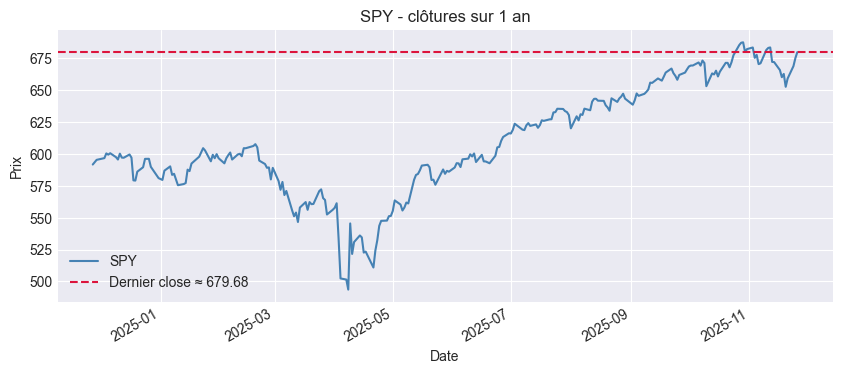

In [2]:

fig, ax = plt.subplots(figsize=(10, 4))
close_spy.plot(ax=ax, color="steelblue", label="SPY close")
ax.axhline(spot_ref, color="crimson", linestyle="--", label=f"Dernier close ≈ {spot_ref:.2f}")
ax.set_title("SPY - clôtures sur 1 an")
ax.set_xlabel("Date")
ax.set_ylabel("Prix")
ax.legend()
plt.show()


## Payoff du condor call long
Plateau de gain entre K2 et K3, pertes bornées. Affichage payoff, P&L net et points morts.


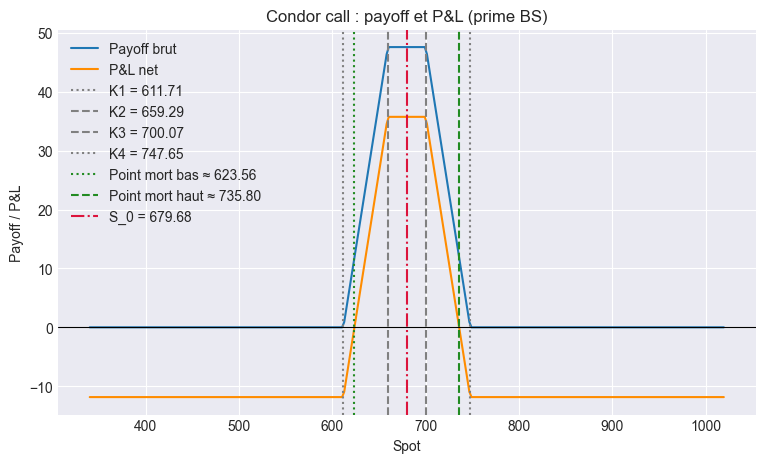

**Prime (BS) ≈ 11.8443**

- Points morts : 623.56 / 735.80
- Plateau central entre K2 et K3.

In [ ]:

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(view_static["s_grid"], view_static["payoff"], label="Payoff brut")
ax.plot(view_static["s_grid"], view_static["pnl"], label="P&L net", color="darkorange")
for k, style, label in [
    (k1, ':', f'K1 = {k1:.2f}'),
    (k2, '--', f'K2 = {k2:.2f}'),
    (k3, '--', f'K3 = {k3:.2f}'),
    (k4, ':', f'K4 = {k4:.2f}'),
]:
    ax.axvline(k, color='gray', linestyle=style, label=label)
ax.axvline(be_low, color="forestgreen", linestyle=":", label=f"Point mort bas ≈ {be_low:.2f}")
ax.axvline(be_high, color="forestgreen", linestyle="--", label=f"Point mort haut ≈ {be_high:.2f}")
ax.axvline(spot_ref, color="crimson", linestyle="-.", label=f"S_0 = {spot_ref:.2f}")
ax.axhline(0, color="black", linewidth=0.8)
ax.set_xlabel("Spot")
ax.set_ylabel("Payoff / P&L")
ax.set_title("Condor call : payoff et P&L (prime BS)")
ax.legend(loc="upper left")
plt.show()

display(Markdown(f"""**Prime (BS) ≈ {premium:.4f}**

- Points morts : {be_low:.2f} / {be_high:.2f}
- Plateau central entre K2 et K3."""))


## Payoff interactif
Curseurs pour S_0, S_T et les quatre strikes. Prime et points morts recalculés dynamiquement.


In [5]:

    spot0_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_0')
    spotT_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_T')
    slider_k1 = widgets.FloatSlider(value=k1, min=spot_ref*0.4, max=spot_ref*1.2, step=1.0, description='K1')
    slider_k2 = widgets.FloatSlider(value=k2, min=spot_ref*0.5, max=spot_ref*1.3, step=1.0, description='K2')
    slider_k3 = widgets.FloatSlider(value=k3, min=spot_ref*0.7, max=spot_ref*1.5, step=1.0, description='K3')
    slider_k4 = widgets.FloatSlider(value=k4, min=spot_ref*0.8, max=spot_ref*1.6, step=1.0, description='K4')
    output = widgets.Output()

    def _update_payoff(change=None):
        with output:
            output.clear_output()
            s0 = spot0_slider.value
            sT = spotT_slider.value
            k1_val = slider_k1.value
            k2_val = slider_k2.value
            k3_val = slider_k3.value
            k4_val = slider_k4.value

            view_dyn = view_condor(s0, k1_val, k2_val, k3_val, k4_val)
            premium_dyn = view_dyn["premium"]
            be_low, be_high = view_dyn["breakevens"]
            payoff_T = float(payoff_condor(sT, k1_val, k2_val, k3_val, k4_val))
            pnl_T = payoff_T - premium_dyn

            fig, ax = plt.subplots(figsize=(7, 4))
            ax.plot(view_dyn["s_grid"], view_dyn["payoff"], label='Payoff brut')
            ax.plot(view_dyn["s_grid"], view_dyn["pnl"], label='P&L net', color='darkorange')
            for k, style, label in [
                (k1_val, ':', f'K1 = {k1_val:.2f}'),
                (k2_val, '--', f'K2 = {k2_val:.2f}'),
                (k3_val, '--', f'K3 = {k3_val:.2f}'),
                (k4_val, ':', f'K4 = {k4_val:.2f}')
            ]:
                ax.axvline(k, color='gray', linestyle=style, label=label)
            ax.axvline(be_low, color='forestgreen', linestyle=':', label=f'Point mort bas ≈ {be_low:.2f}')
            ax.axvline(be_high, color='forestgreen', linestyle='--', label=f'Point mort haut ≈ {be_high:.2f}')
            ax.axvline(s0, color='crimson', linestyle='-.', label=f'S_0 = {s0:.2f}')
            ax.axhline(0, color='black', linewidth=0.8)
            ax.scatter([sT], [pnl_T], color='gold', zorder=5, label=f'P&L à S_T = {pnl_T:.2f}')
            ax.set_xlabel('Spot')
            ax.set_ylabel('Payoff / P&L')
            ax.legend(loc='lower right')
            ax.set_title('Payoff et P&L du condor')
            plt.show()

            display(Markdown(f"""**S_0 = {s0:.2f}**, **S_T = {sT:.2f}**

- K1 = {k1_val:.2f}
- K2 = {k2_val:.2f}
- K3 = {k3_val:.2f}
- K4 = {k4_val:.2f}
- Prix (BS) = {premium_dyn:.4f}
- Payoff à l'expiration = {payoff_T:.4f}
- P&L net = {pnl_T:.4f}
- Points morts ≈ {be_low:.2f} / {be_high:.2f}"""))

    for sl in (spot0_slider, spotT_slider, slider_k1, slider_k2, slider_k3, slider_k4):
        sl.observe(_update_payoff, names='value')

    _update_payoff()
    display(widgets.VBox([spot0_slider, spotT_slider, slider_k1, slider_k2, slider_k3, slider_k4, output]))
